# Anomaly Detection with GANs for Multivariate Time Series
https://arxiv.org/pdf/1809.04758.pdf

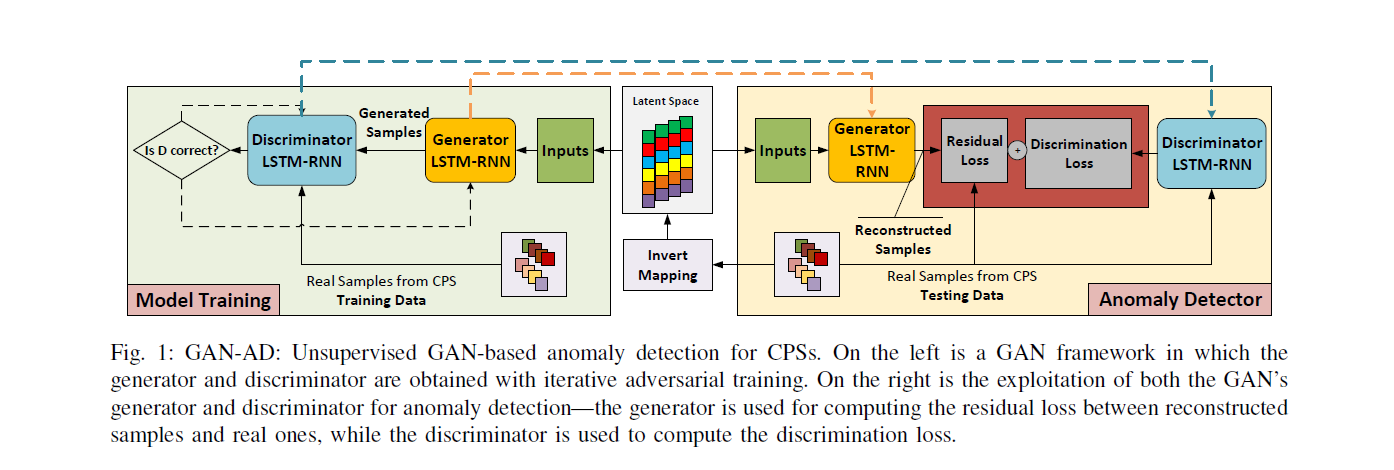

In [59]:
import os
import pandas as pd
import numpy as np
from time_series_anomaly_detection.detector import GAN_AD
import random
from datetime import date
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Skoltech Anomaly Benchmark (SKAB) dataset

Iurii D. Katser and Vyacheslav O. Kozitsin, “Skoltech Anomaly Benchmark (SKAB).” Kaggle, 2020, doi: 10.34740/KAGGLE/DSV/1693952.

https://www.kaggle.com/yuriykatser/skoltech-anomaly-benchmark-skab <br>
https://github.com/waico/SKAB

## Data preparation

In [2]:
# single multivariate time series
df_anomaly_free = pd.read_csv("../datasets/skab/anomaly-free/anomaly-free.csv", index_col='datetime', sep=';',parse_dates=True).reset_index(drop=True)

Original data - example visualisation

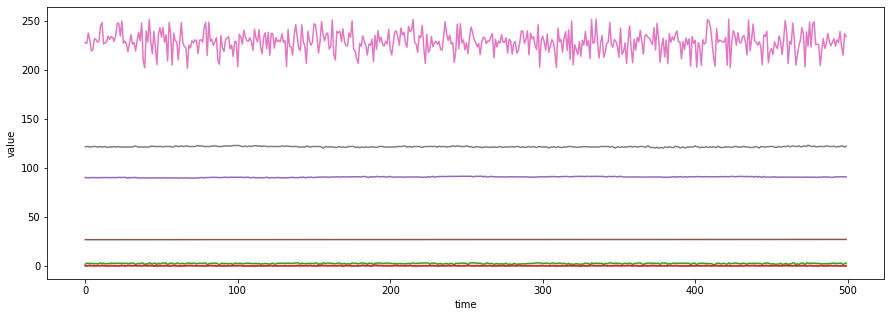

In [19]:
display(Markdown('Original data - example visualisation'))
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('value')
plt.plot(df_anomaly_free[:500])
plt.show()

In [3]:
ratio = 0.75
split = int(len(df_anomaly_free)*ratio)
df_anomaly_free, df_test = df_anomaly_free.iloc[:split,:].reset_index(drop=True), df_anomaly_free.iloc[split:,:].reset_index(drop=True)

In [4]:
ratio = 0.5
split = int(len(df_test)*ratio)
df_anomaly_free_test, df_with_anomalies = df_test.iloc[:split,:].reset_index(drop=True), df_test.iloc[split:,:].reset_index(drop=True)

In [5]:
# insert dummy fake anomalies
random.seed(10)
anomaly_index = random.sample(range(0, df_with_anomalies.shape[0]), int(0.2*df_with_anomalies.shape[0]))
df_with_anomalies.iloc[anomaly_index, [0,1,4]] = df_with_anomalies.iloc[anomaly_index, [0,1,4]] * 0.95
df_with_anomalies.iloc[anomaly_index, [2,6]] = df_with_anomalies.iloc[anomaly_index, [2,6]] * 1.1
# df_with_anomalies.describe()

In [6]:
df_anomalies_labels = df_with_anomalies.copy()
df_anomalies_labels['label'] = 0
df_anomalies_labels.iloc[anomaly_index, :] = 1
df_anomalies_labels = df_anomalies_labels.drop(columns=['Accelerometer1RMS','Accelerometer2RMS','Current','Pressure','Temperature','Thermocouple','Voltage','Volume Flow RateRMS'])

## Hyperparameter settings

The selected values appeared during the performed experiments as the most promising. 
"Finer" search was not conducted as this is only a toy-example demonstration, and the detector won't be used on this data.
I recommend using coarse to fine technique to find the most optimal set of hyper-parameters if needed.

In [7]:
window_size = 16
shift = 5
batch_size = 32
latent_dim = 2 
epochs = 10000

## Training

In [41]:
gan_ad = GAN_AD(window_size = window_size, shift = shift, batch_size = batch_size, latent_dim = latent_dim)
gan_ad.fit(df_anomaly_free, epochs, save_checkpoints=True, enable_prints=True)
gan_ad.save_model("gan_ad_" + str(date.today()) + "-skab.h5")

As the loss function in the last training epochs slightly deteriorated, I used the weights from the model saved in the 9000th epoch.

In [9]:
# gan_ad.load_weights("gan_ad_2021-05-01_epoch_9000.h5")
# gan_ad.fit_scaler(df_anomaly_free)

## Evaluation demonstration

### Anomaly free (training) data

In [10]:
# data shorter than one window returns NaN Series
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free[0:0+window_size-5]))
anomaly_scores

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
dtype: float64

Anomaly free (training) data with NaNs - anomaly scores

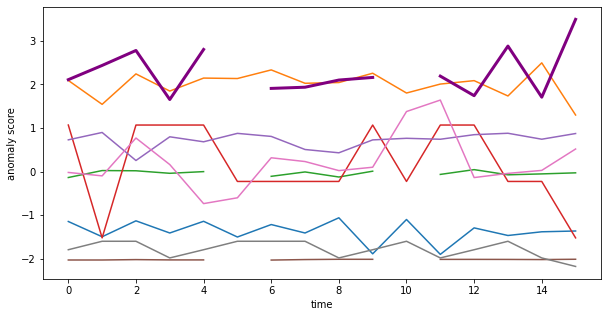

In [66]:
# one window with NaN values
window_with_nan = pd.DataFrame(df_anomaly_free[0:0+window_size].copy())
window_with_nan.iloc[[5,10], [2,5]] = np.nan

display(Markdown('Anomaly free (training) data with NaNs - anomaly scores'))
anomaly_scores = gan_ad.predict_anomaly_scores(window_with_nan)
data = gan_ad.transform_data(window_with_nan)
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('anomaly score')
plt.plot(data)
plt.plot(anomaly_scores, color='purple', lw=3)
plt.show()

Anomaly free (training) data - anomaly scores

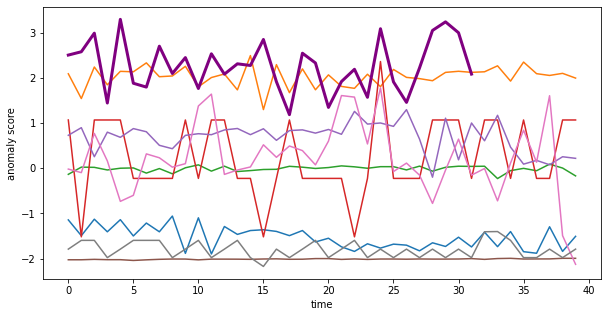

In [63]:
# more than one window
display(Markdown('Anomaly free (training) data - anomaly scores'))
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free[0:(2*window_size)+8]))
data = gan_ad.transform_data(pd.DataFrame(df_anomaly_free[0:(2*window_size)+8]))
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('anomaly score')
plt.plot(data)
plt.plot(anomaly_scores, color='purple', lw=3)
plt.show()

In [27]:
# average anomaly score
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free[0:(100*window_size)]))
avg_score = anomaly_scores.sum()/(100*window_size)
display(Markdown('Anomaly free (training) data - Average anomaly score: %.2f' % avg_score))

Anomaly free (training) data - Average anomaly score: 2.14

### Anomaly free (test) data

Anomaly free (test) data - anomaly scores

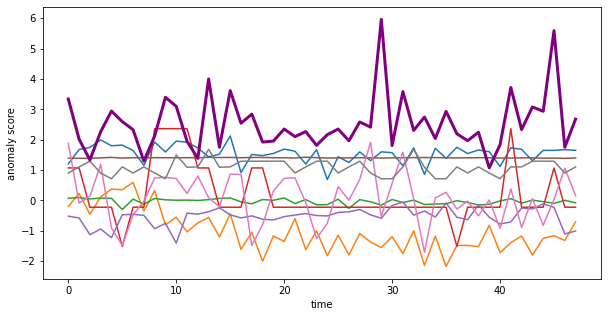

In [62]:
# more than one window
display(Markdown('Anomaly free (test) data - anomaly scores'))
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free_test[0:(3*window_size)]))
data = gan_ad.transform_data(pd.DataFrame(df_anomaly_free_test[0:3*window_size]))
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('anomaly score')
plt.plot(data)
plt.plot(anomaly_scores, color='purple', lw=3)
plt.show()

In [28]:
# average anomaly score
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free_test[0:(100*window_size)]))
avg_score = anomaly_scores.sum()/(100*window_size)
display(Markdown('Anomaly free (test) data - Average anomaly score: %.2f' % avg_score))

Anomaly free (test) data - Average anomaly score: 1.81

### Data with (inserted) anomalies

Original data with anomalies

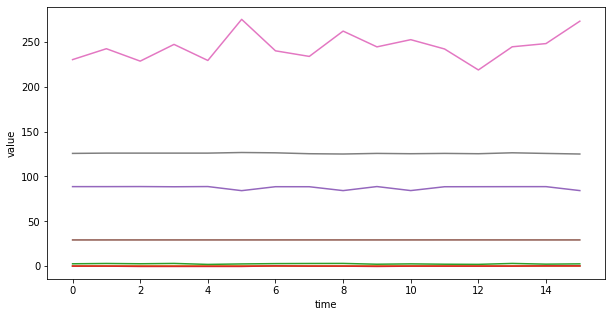

Scaled data with anomalies - true anomalies

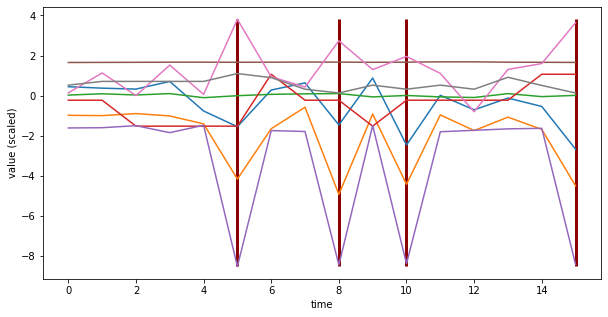

Scaled data with anomalies - predicted anomaly scores

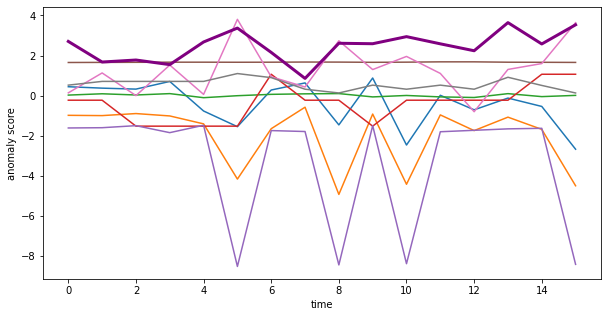

Scaled data with anomalies - predicted anomalies

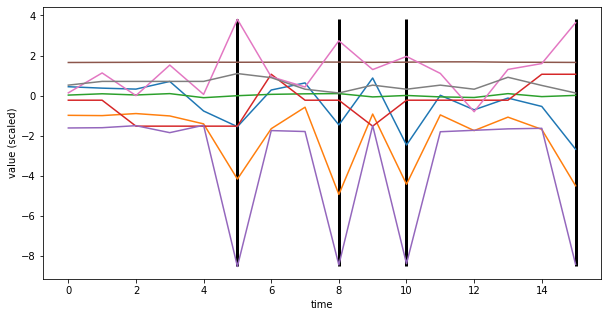

In [61]:
# one window
display(Markdown('Original data with anomalies'))
data = pd.DataFrame(df_with_anomalies[0:window_size])
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('value')
plt.plot(data)
plt.show()

display(Markdown('Scaled data with anomalies - true anomalies'))
data = gan_ad.transform_data(pd.DataFrame(df_with_anomalies[0:window_size]))
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel("value (scaled)")
plt.plot(data)
labels = pd.DataFrame(df_anomalies_labels[0:window_size]).replace(0,np.nan).dropna().index
plt.vlines(x=labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='darkred', ls='-', lw=3, label='vline_single - full height')
plt.show()

display(Markdown('Scaled data with anomalies - predicted anomaly scores'))
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free_test[0:0+window_size]))
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('anomaly score')
plt.plot(data)
plt.plot(anomaly_scores, color='purple', lw=3)
plt.show()

display(Markdown('Scaled data with anomalies - predicted anomalies'))
predicted = gan_ad.identify_anomaly(pd.DataFrame(df_with_anomalies[0:window_size]), threshold = 2)
predicted_labels = pd.DataFrame(predicted).replace(0,np.nan).dropna().index
plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel("value (scaled)")
plt.plot(data)
plt.vlines(x=predicted_labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='black', ls='-', lw=3, label='vline_single - full height')
plt.show()

Original data with anomalies

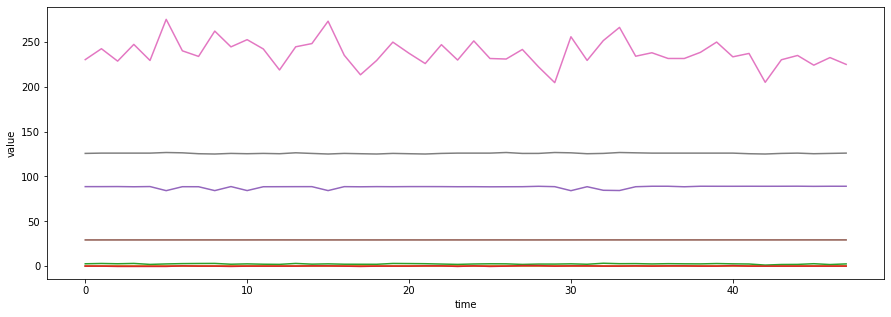

Scaled data with anomalies - true anomalies

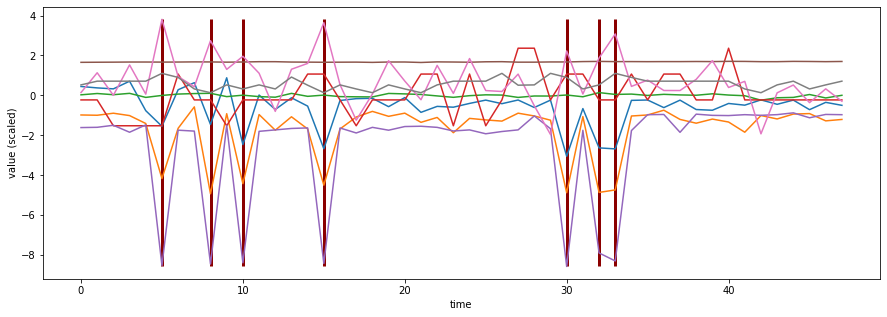

Scaled data with anomalies - predicted anomaly scores

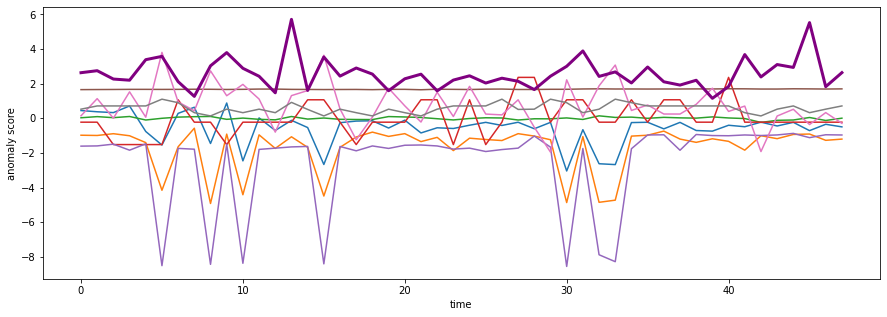

Scaled data with anomalies - predicted anomalies

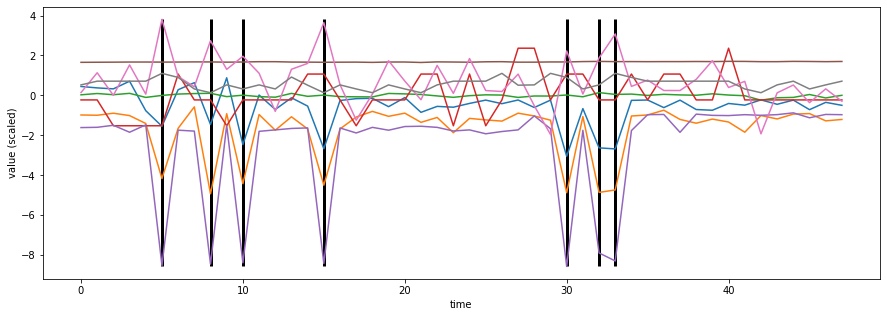

In [60]:
# more than one window
display(Markdown('Original data with anomalies'))
data = pd.DataFrame(df_with_anomalies[0:(3*window_size)])
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('value')
plt.plot(data)
plt.show()

display(Markdown('Scaled data with anomalies - true anomalies'))
data = gan_ad.transform_data(pd.DataFrame(df_with_anomalies[0:(3*window_size)]))
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel("value (scaled)")
plt.plot(data)
labels = pd.DataFrame(df_anomalies_labels[0:(3*window_size)]).replace(0,np.nan).dropna().index
plt.vlines(x=labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='darkred', ls='-', lw=3, label='vline_single - full height')
plt.show()

display(Markdown('Scaled data with anomalies - predicted anomaly scores'))
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free_test[0:(3*window_size)]))
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('anomaly score')
plt.plot(data)
plt.plot(anomaly_scores, color='purple', lw=3)
plt.show()

display(Markdown('Scaled data with anomalies - predicted anomalies'))
predicted = gan_ad.identify_anomaly(pd.DataFrame(df_with_anomalies[0:(3*window_size)]), threshold = 2)
predicted_labels = pd.DataFrame(predicted).replace(0,np.nan).dropna().index
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel("value (scaled)")
plt.plot(data)
plt.vlines(x=predicted_labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='black', ls='-', lw=3, label='vline_single - full height')
plt.show()

In [30]:
# average anomaly score
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_with_anomalies[0:(100*window_size)]))
avg_score = anomaly_scores.sum()/(100*window_size)
display(Markdown('Data with anomalies - Average anomaly score: %.2f' % avg_score))

Data with anomalies - Average anomaly score: 2.67

In [53]:
y_true = np.array(df_anomalies_labels[0:(100*window_size)])

In [39]:
predicted = gan_ad.identify_anomaly(pd.DataFrame(df_with_anomalies[0:(100*window_size)]), threshold = 2)
y_pred = np.array(predicted)

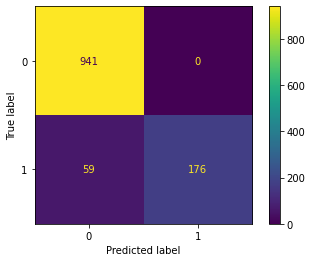

In [58]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
disp.plot()